<a href="https://colab.research.google.com/github/borgesf/TimeShift1D/blob/main/TimeShift_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seismic Time-Shift and Strain Analysis

This notebook builds and compares a baseline and a monitor velocity model, computes time-shifts, and visualizes the results.

---

## 1. Setup and Imports

First, import the necessary libraries and set up inline plotting.

In [ ]:
# Enable inline plotting in Colab
%matplotlib inline


# Importing libraries
import numpy as np
import matplotlib.pyplot as plt

# Set global font properties for plotting
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['DejaVu Sans', 'Liberation Sans', 'sans-serif'],
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

print("Libraries imported successfully.")

Libraries imported successfully.


In [ ]:
# Cell 1: Building velocity profile

# Baseline
thickness_baseline = np.array([100.0, 100.0])        # thickness in meters
vp_baseline_vals   = np.array([2200, 2500.0])      # velocity in m/s

# Monitor: add gas cap
gas_cap_thickness  = 50.0
gas_cap_velocity   = 2000.0

thickness_monitor  = np.r_[gas_cap_thickness, thickness_baseline]
vp_monitor_vals    = np.r_[gas_cap_velocity,  vp_baseline_vals]

print("Baseline thicknesses:", thickness_baseline)
print("Monitor thicknesses:", thickness_monitor)

# Depth axis
dz          = 1.0                              # depth increment (m)
depth_start = 2000.0                           # starting depth (m)
rel_depth   = np.arange(0.0, thickness_monitor.sum()+dz, dz)
abs_depth   = depth_start + rel_depth          # absolute depth (m)

# Contacts
goc = depth_start + gas_cap_thickness          # gas-oil contact
owc = goc + thickness_baseline[0]              # oil-water contact

print(f"GOC at {goc:.1f} m, OWC at {owc:.1f} m")

# Velocity logs
def build_log(thick, vals, rel_d):
    """
    Repeat each velocity value vals[i] for the number of samples
    in layer i, given by thickness array thick.
    """
    tops    = np.r_[0.0, np.cumsum(thick)[:-1]]
    idx     = np.searchsorted(rel_d, tops)
    counts  = np.diff(np.r_[idx, len(rel_d)])
    return np.repeat(vals, counts)

vp_base = build_log(thickness_baseline, vp_baseline_vals, rel_depth)
vp_mon  = build_log(thickness_monitor,  vp_monitor_vals,   rel_depth)


Baseline thicknesses: [100. 100.]
Monitor thicknesses: [ 50. 100. 100.]
GOC at 2050.0 m, OWC at 2150.0 m


In [ ]:
# Cell 2: Slowness and TWT
slo_base    = 1.0 / vp_base
slo_mon     = 1.0 / vp_mon

# Multiply by 2000 thousand to get the two-way traveltine in miliseconds

twt_base_ms = np.cumsum(slo_base * dz) * 2000.0
twt_mon_ms  = np.cumsum(slo_mon  * dz) * 2000.0

In [ ]:
# Cell 3: Time-shift
time_shift_ms = twt_base_ms - twt_mon_ms

print("Computed time-shift.")

Computed time-shift.


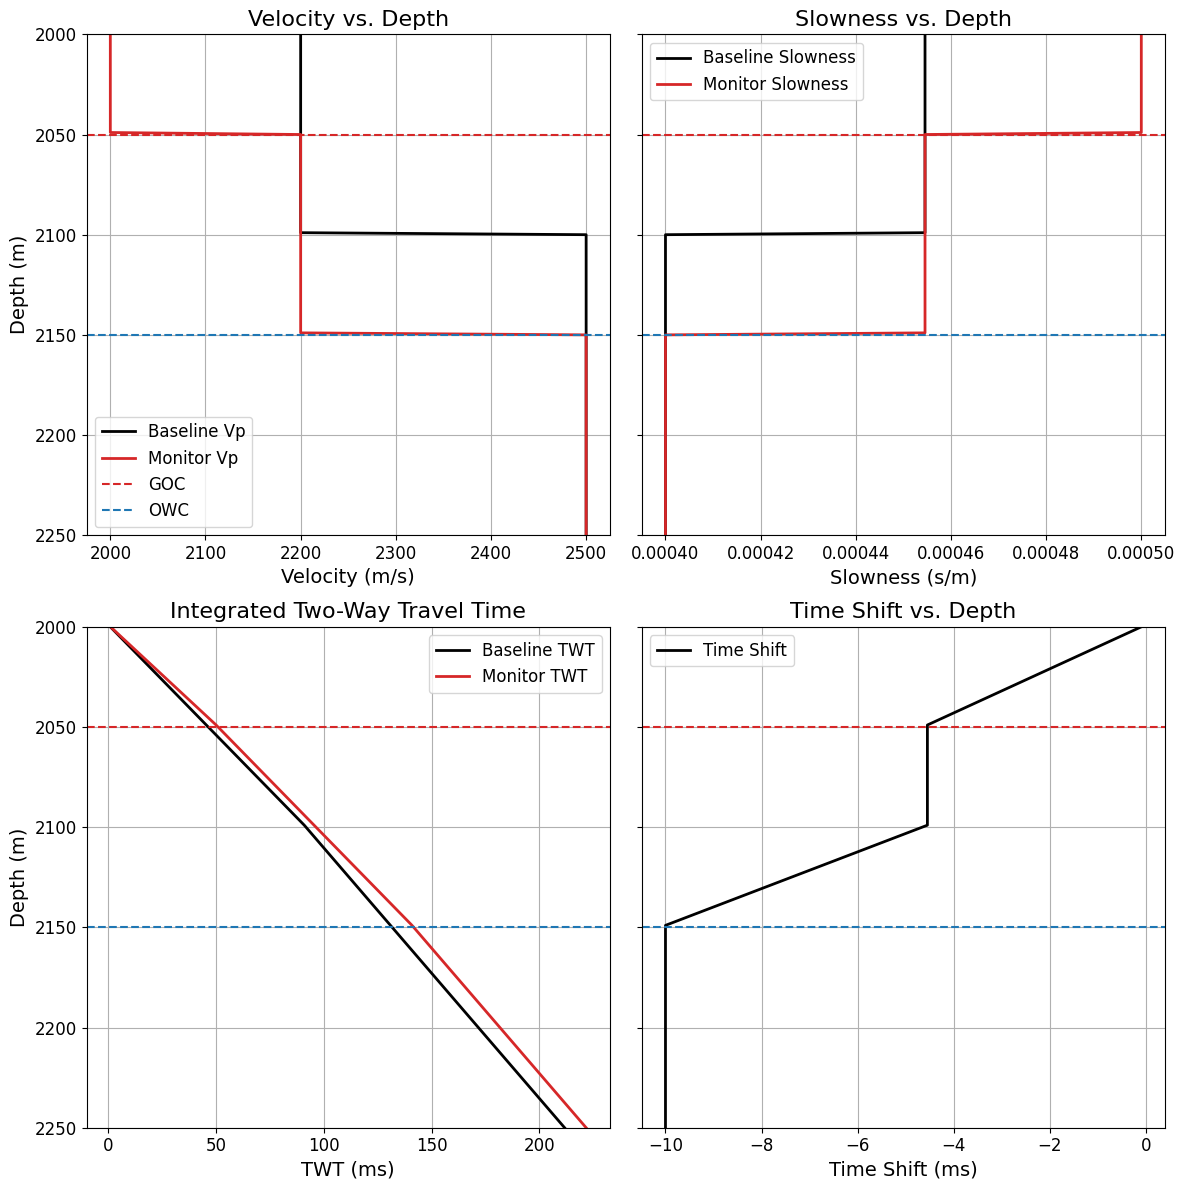

In [ ]:
# Cell 4: Plotting for visual inspection
fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharey=True)
ylim = (abs_depth[0], abs_depth[-1])

# Define common properties
line_width = 2
goc_style = {'color': 'tab:red', 'linestyle': '--'}
owc_style = {'color': 'tab:blue', 'linestyle': '--'}

# Reverse Y axis
ylim = (abs_depth[-1], abs_depth[0])

# === Panel 1: Velocity ===
ax = axes[0, 0]
ax.plot(vp_base, abs_depth, color='black', linewidth=line_width, label='Baseline Vp')
ax.plot(vp_mon, abs_depth, color='tab:red', linewidth=line_width, label='Monitor Vp')
ax.axhline(goc, **goc_style, label='GOC')
ax.axhline(owc, **owc_style, label='OWC')
ax.set_xlabel('Velocity (m/s)')
ax.set_ylabel('Depth (m)')
ax.set_title('Velocity vs. Depth')
ax.set_ylim(ylim)
ax.grid(True)
ax.legend()

# === Panel 2: Slowness ===
ax = axes[0, 1]
ax.plot(slo_base, abs_depth, color='black', linewidth=line_width, label='Baseline Slowness')
ax.plot(slo_mon, abs_depth, color='tab:red', linewidth=line_width, label='Monitor Slowness')
ax.axhline(goc, **goc_style)
ax.axhline(owc, **owc_style)
ax.set_xlabel('Slowness (s/m)')
ax.set_title('Slowness vs. Depth')
ax.set_ylim(ylim)
ax.grid(True)
ax.legend()

# === Panel 3: Integrated TWT ===
ax = axes[1, 0]
ax.plot(twt_base_ms, abs_depth, color='black', linewidth=line_width, label='Baseline TWT')
ax.plot(twt_mon_ms, abs_depth, color='tab:red', linewidth=line_width, label='Monitor TWT')
ax.axhline(goc, **goc_style)
ax.axhline(owc, **owc_style)
ax.set_xlabel('TWT (ms)')
ax.set_ylabel('Depth (m)')
ax.set_title('Integrated Two-Way Travel Time')
ax.set_ylim(ylim)
ax.grid(True)
ax.legend()

# === Panel 4: Time Shift ===
ax = axes[1, 1]
ax.plot(time_shift_ms, abs_depth, color='black', linewidth=line_width, label='Time Shift')
ax.axhline(goc, **goc_style)
ax.axhline(owc, **owc_style)
ax.set_xlabel('Time Shift (ms)')
ax.set_title('Time Shift vs. Depth')
ax.set_ylim(ylim)
ax.grid(True)
ax.legend()

# Layout
plt.tight_layout()
plt.savefig("velocity_analysis_full.png", dpi=300, bbox_inches='tight')
plt.show()
